<a href="https://colab.research.google.com/github/markcastorm/NLP-with-Disaster-Tweet-/blob/main/NLP_with_Disaster_Tweet_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [ ]:
for i in [0,2,3]:
    if i%2 == 0:
        print("even")
    elif i == 0:
        print("zero")
    else:
        print("odd")

even
even
odd


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

import re
import string
!pip install emoji
import emoji

import warnings
warnings.filterwarnings('ignore')


     |████████████████████████████████| 170 kB 7.4 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=5c8ec72e1f22282df240080a6fa5be62c2ce0b7d4d2a2ff977bb29d859308d43
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


In [ ]:
array_1 =np.array([[1, 2, 7], [3,4, 8]])
array_2 =np.array([[1, 2], [3,9],[4, 16]])

np.dot(array_1, array_2)

array([[ 35, 132],
       [ 47, 170]])

In [ ]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [ ]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
print("Total rows in train data:", train_data.shape[0])
print("Total columns in train data:", train_data.shape[1])
print("_"*30)
print("Total rows in test data:", test_data.shape[0])
print("Total columns in test data:", test_data.shape[1])

Total rows in train data: 7613
Total columns in train data: 5
______________________________
Total rows in test data: 3263
Total columns in test data: 4


Checking for null data. Since keyword and location columns has null value i am going to drop them

In [ ]:
print(train_data.isnull().sum())
print("_"*30)
print(test_data.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
______________________________
id             0
keyword       26
location    1105
text           0
dtype: int64


Counting and visualizing total positive and negative target in our training data

In [ ]:
train_data.groupby(train_data.target).count().text

target
0    4342
1    3271
Name: text, dtype: int64

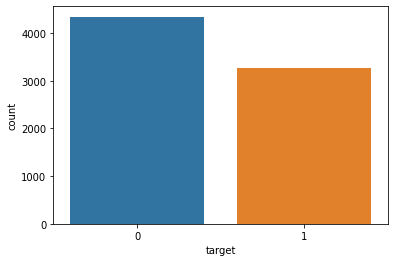

In [ ]:
sns.countplot(train_data.target, data = train_data)
plt.show()

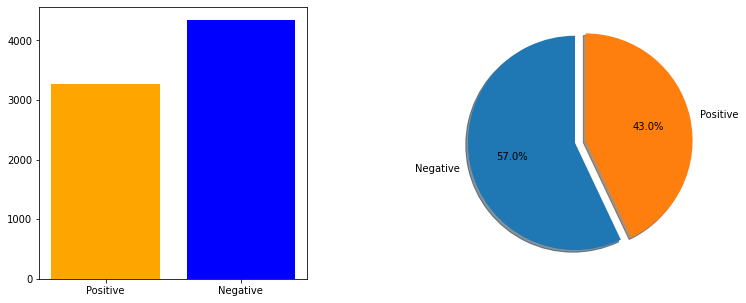

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (12,5),constrained_layout=True)
plt.subplots_adjust(wspace = 0.5)

negative_count = train_data.target.value_counts().tolist()[0]
positive_count = train_data.target.value_counts().tolist()[1]

ax1.bar(train_data.target.unique(),train_data.target.value_counts(),color = ['blue', 'orange'],width =0.8)
ax1.set_xticks(train_data.target.unique())
ax1.set_xticklabels(('Negative','Positive'))

ax2.pie((negative_count, positive_count), labels = ('Negative','Positive'), autopct='%1.1f%%', shadow=True, startangle=90, explode=[0,0.1])
plt.show()

Here, I am going to use only text column for analysis so I am dropping other columns¶

In [ ]:
train_data = train_data.iloc[:,3:]
test_data = test_data.iloc[:,3:]


##Cleaning tweets

Cleaning process involves removal of emojis,hyperlink,punctuations and many more.


In [ ]:
def cleanTweet(txt):
    txt = re.sub(r'@[A-Za-z0-9_]+','',txt)
    txt = re.sub(r'#','',txt)
    txt = re.sub(r'RT : ','',txt)
    txt = re.sub(r'\n','',txt)
    # to remove emojis
    txt = re.sub(emoji.get_emoji_regexp(), r"", txt)
    txt = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+','',txt)
    txt = re.sub(r"https?://\S+|www\.\S+","",txt)
    txt = re.sub(r"<.*?>","",txt)
    return txt

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

def make_Lower(text):
    return str.lower(text)



In [ ]:
print("Tweet before cleaning::", train_data.text[200])
print("Tweet after cleaning:: ",train_data.text.apply(cleanTweet)[200])

Tweet before cleaning:: HAPPENING NOW - HATZOLAH EMS AMBULANCE RESPONDING WITH DUAL SIRENS ANDÛ_ https://t.co/SeK6MQ6NJF
Tweet after cleaning::  HAPPENING NOW - HATZOLAH EMS AMBULANCE RESPONDING WITH DUAL SIRENS ANDÛ_ 


In [ ]:
text = "#@Hello &World"
print(remove_punct(text))

Hello World


In [ ]:
text = 'HELLO WORLD'
print(make_Lower(text))

hello world


In [ ]:
train_data.text = train_data.text.apply(cleanTweet)
train_data.text = train_data.text.apply(remove_punct)
train_data.text = train_data.text.apply(make_Lower)

test_data.text = test_data.text.apply(cleanTweet)
test_data.text = test_data.text.apply(remove_punct)
test_data.text = test_data.text.apply(make_Lower)


In [ ]:
!pip install pyspellchecker

In [ ]:

from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

text = "speling mistke"
correct_spellings(text)

'spelling mistake'

 You can use this function to correct spellings
 train_data.text = train_data.text.apply(correct_spellings)
 test_data.text = test_data.text.apply(correct_spellings)

Removing Stopwords from data

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = set(stopwords.words('english'))
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
train_data.text = train_data.text.apply(remove_stopwords)
test_data.text = test_data.text.apply(remove_stopwords)


Definning Hyperparameters

In [ ]:
vocab = 20000
oov = '<OOV>'
embedding = 32
padding = 'post'
truncate = 'post'



In [ ]:
# import necessary libraries for text preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


In [ ]:
# preparing training data
train_ = train_data.drop('target',axis = 1)
train_y = train_data.target

Here I have splitted training data to train and validation data to check the performance of model

In [ ]:

train_size = 0.8
size = int(train_size * train_data.shape[0])
train_x_data = train_.iloc[:size,:]
train_y_data =  train_y.iloc[:size]
print("Shape of X train data: ",train_x_data.shape)
print("Shape of Y train data",train_x_data.shape)

validation_x_data = train_.iloc[size:,:]
validation_y_data =  train_y.iloc[size:]
print("Shape of X validation data: ",validation_x_data.shape)
print("Shape of Y validation data",validation_x_data.shape)


Shape of X train data:  (6090, 1)
Shape of Y train data (6090, 1)
Shape of X validation data:  (1523, 1)
Shape of Y validation data (1523, 1)


In [ ]:
tokenizer = Tokenizer(num_words = vocab, oov_token = oov)
tokenizer.fit_on_texts(train_x_data.text)
word_index = tokenizer.word_index
print("Length: ",len(word_index))


Length:  13831


In [ ]:
training_x = tokenizer.texts_to_sequences(train_x_data.text)
training_x_pad = pad_sequences(training_x,maxlen=25, padding=padding, truncating=truncate)

validation_x = tokenizer.texts_to_sequences(validation_x_data.text)
validation_x_pad = pad_sequences(validation_x,maxlen=25, padding=padding, truncating=truncate)

training_y = train_y_data.values
validation_y = validation_y_data.values

###Defining our model

In [ ]:
print(3**3)

27


In [ ]:
import tensorflow as tf
import keras
from keras import layers

def give_model():
    model = keras.models.Sequential()
    model.add(layers.Embedding(vocab, embedding, input_length=25))
    model.add(layers.Bidirectional(layers.LSTM(128,return_sequences = True)))
    model.add(layers.LSTM(64))
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(units = 10,activation = 'relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(units = 1, activation = 'sigmoid'))


    return model
model = give_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 32)            640000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 25, 256)           164864    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)               

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 2, mode = 'min', min_delta = 0.01)
LOSS = tf.keras.losses.BinaryCrossentropy()
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate = 0.001)
EPOCHS = 30
VALIDATION_DATA = (validation_x_pad,validation_y)
model.compile(loss = LOSS, optimizer = OPTIMIZER, metrics = ['accuracy'])

In [ ]:
history = model.fit(training_x_pad, training_y, epochs = EPOCHS, validation_data = VALIDATION_DATA,
                   callbacks = [early_stopping])

Epoch 1/30
191/191 [==============================] - 25s 97ms/step - loss: 0.6562 - accuracy: 0.6008 - val_loss: 0.4906 - val_accuracy: 0.7794
Epoch 2/30
191/191 [==============================] - 16s 85ms/step - loss: 0.3332 - accuracy: 0.8836 - val_loss: 0.4989 - val_accuracy: 0.7774
Epoch 3/30
191/191 [==============================] - 16s 84ms/step - loss: 0.2203 - accuracy: 0.9359 - val_loss: 0.5525 - val_accuracy: 0.7695


Visualizing our model performance

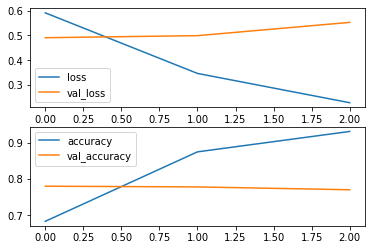

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.legend(loc = 'best')
plt.subplot(2,1,2)
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend(loc = 'best')
plt.show()

Training our model in all train data

In [ ]:
tokenizer = Tokenizer(num_words = vocab, oov_token = oov)
tokenizer.fit_on_texts(train_.text)
word_index = tokenizer.word_index
print("length: ",len(word_index))

training_x = tokenizer.texts_to_sequences(train_.text)
training_x_pad = pad_sequences(training_x,maxlen=25, padding=padding, truncating=truncate)

testing_x_data = tokenizer.texts_to_sequences(test_data.text)
testing_x_pad = pad_sequences(testing_x_data,maxlen=25, padding=padding, truncating=truncate)

training_y = train_y.values


length:  15969


Fitting our data

In [ ]:
model.fit(training_x_pad, training_y, epochs = 3)

Epoch 1/3
238/238 [==============================] - 19s 79ms/step - loss: 0.6852 - accuracy: 0.5688
Epoch 2/3
238/238 [==============================] - 19s 81ms/step - loss: 0.5220 - accuracy: 0.7513
Epoch 3/3
238/238 [==============================] - 20s 86ms/step - loss: 0.2836 - accuracy: 0.8993


###For submission

In [ ]:
prediction = model.predict(testing_x_pad)
predicted_value = (prediction > 0.5).astype(int)

In [ ]:
submission = pd.read_csv("sample_submission.csv")
submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [ ]:
def Get():
    x1=eva(input ("Enter first number"))
    X2=eva(input("Enter sec nUmber"))
    print("Answer = " ,(x1+X2))


Get()

NameError: ignored

In [ ]:
class Rectangle:
   L = int(input ("enter the length"))
   W = int(input ("enter the width"))
   def Calculate (self):
       print("Area is",self.L*self.W)
R=Rectangle ()
R.Calculate()

enter the length13
enter the width13
Area is 169


In [ ]:


scores = int(input ("enter scores"))
if scores >= 70 and scores <= 100:
        print("A")
elif scores >= 60 and scores <= 69:
        print('B')
elif scores >= 50 and scores <= 59:
        print("c")
elif scores >= 40 and scores <= 49:
        print("D")
elif scores >= 0 and scores <= 39:
        print("E")
else:
        print("invalid")

enter scores80
A


In [ ]:
for i in range (3,100):
   print(i, end=",")

3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,

In [ ]:

i=3
while(i<=100):
   print (i,end=",")
   i=i+2

3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65,67,69,71,73,75,77,79,81,83,85,87,89,91,93,95,97,99,

In [ ]:
i=1
while (i!=0):
   x1=int(input("enter first no"))
   x2=int(input("Enter second no"))
print("sum is", (x1+x2))
i=int(input("enter 0 to exit or any number to continue"))

KeyboardInterrupt: ignored

In [ ]:
l1=list()
l2=list()
l3=list()

F="XYZ"

while(F !="stop"):
     x= input("select A,B,C")
     if(x==A):
       l1.append(x)
     elif(x==B):
       l2.append(x)
     elif (x==C):
       l3.append(x)
     else :
       print("invalid vote")

     F = input("Enter stop to exit or any character to continue")
print("A gunnered", len(l1), "votes")
print("A gunnered", len(l2), "votes")
print("A gunnered", len(l3), "votes")

select A,B,CA


NameError: ignored

In [ ]:
# Run this cell without changes
frontier_restaurant = {'categories': [{'alias': 'mexican', 'title': 'Mexican'},
  {'alias': 'diners', 'title': 'Diners'},
  {'alias': 'tradamerican', 'title': 'American (Traditional)'}],
 'coordinates': {'latitude': 35.0808088832532, 'longitude': -106.619402244687},
 'display_phone': '(505) 266-0550',
 'distance': 4033.6583235266075,
 'id': 'frontier-restaurant-albuquerque-2',
 'image_url': 'https://s3-media4.fl.yelpcdn.com/bphoto/M9L2z6-G0NobuDJ6YTh6VA/o.jpg',
 'is_closed': False,
 'location': {'address1': '2400 Central Ave SE',
  'address2': '',
  'address3': '',
  'city': 'Albuquerque',
  'country': 'US',
  'display_address': ['2400 Central Ave SE', 'Albuquerque, NM 87106'],
  'state': 'NM',
  'zip_code': '87106'},
 'name': 'Frontier Restaurant',
 'phone': '+15052660550',
 'price': '$',
 'rating': 4.0,
 'review_count': 1369,
 'transactions': [],
 'url': 'https://www.yelp.com/biz/frontier-restaurant-albuquerque-2?adjust_creative=SYc8R4Gowqru5h4SBKZXsQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=SYc8R4Gowqru5h4SBKZXsQ'}



In [ ]:
print("The required call result : " + str(frontier_restaurant['name']))

The required call result : Frontier Restaurant


In [ ]:
def restaurant_name(frontier_restaurant):
  frontier_restaurant = {'categories': [{'alias': 'mexican', 'title': 'Mexican'},
  {'alias': 'diners', 'title': 'Diners'},
  {'alias': 'tradamerican', 'title': 'American (Traditional)'}],
 'coordinates': {'latitude': 35.0808088832532, 'longitude': -106.619402244687},
 'display_phone': '(505) 266-0550',
 'distance': 4033.6583235266075,
 'id': 'frontier-restaurant-albuquerque-2',
 'image_url': 'https://s3-media4.fl.yelpcdn.com/bphoto/M9L2z6-G0NobuDJ6YTh6VA/o.jpg',
 'is_closed': False,
 'location': {'address1': '2400 Central Ave SE',
  'address2': '',
  'address3': '',
  'city': 'Albuquerque',
  'country': 'US',
  'display_address': ['2400 Central Ave SE', 'Albuquerque, NM 87106'],
  'state': 'NM',
  'zip_code': '87106'},
 'name': 'Frontier Restaurant',
 'phone': '+15052660550',
 'price': '$',
 'rating': 4.0,
 'review_count': 1369,
 'transactions': [],
 'url': 'https://www.yelp.com/biz/frontier-restaurant-albuquerque-2?adjust_creative=SYc8R4Gowqru5h4SBKZXsQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=SYc8R4Gowqru5h4SBKZXsQ'}



  print("The required call result : " + str(frontier_restaurant['name']))



restaurant_name(frontier_restaurant)


# calling function using brackets
  #  res = frontier_restaurant['name']()

# printing result
  #  print("The required call result : " + str(frontier_restaurant))

#     print(frontier_restaurant.get('name'))



    # Replace None with appropriate code
#     None

# frontier_restaurant.values()



The required call result : Frontier Restaurant


In [ ]:
    def myFun(): # define function name
        print(" Welcome to JavaTpoint")
    myFun() # call to print the statement


 Welcome to JavaTpoint


In [ ]:
dict1 = {
    'age': 23,
    'lifespan':75
    }

dict2={'age':45, 'lifespan':70}

if dict1['age'] > dict2['age'] :
   print("True")
else :
   print("False")


False
